Importamos los paquetes necesarios

In [669]:
import cv2
import imutils
import numpy as np
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
from PIL import Image

Cargamos nuestras imagenes

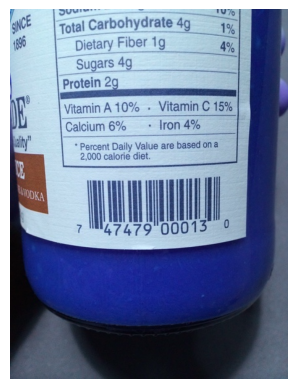

In [670]:
# img = cv2.imread('img/test/barcode_detector_test_025565.jpg', cv2.IMREAD_COLOR) #1º
# img = cv2.imread('img/test/Barcodes_val_010985.jpg', cv2.IMREAD_COLOR) #-45º
# img = cv2.imread('img/test/barcode_detector_train_025407.jpg', cv2.IMREAD_COLOR) #87º
# img = cv2.imread('img/test/thisisnotgood_val_016289.jpg', cv2.IMREAD_COLOR) #-23º
# img = cv2.imread('img/train/barcode_detector_test_025552.jpg', cv2.IMREAD_COLOR) #133º
# img = cv2.imread('images/barcode_01.jpg', cv2.IMREAD_COLOR) #47º
# img = cv2.imread('images/barcode_02.jpg', cv2.IMREAD_COLOR) #-23º
# img = cv2.imread('images/barcode_03.jpg', cv2.IMREAD_COLOR) #-45º
# img = cv2.imread('images/barcode_04.jpg', cv2.IMREAD_COLOR) #87º
# img = cv2.imread('images/barcode_05.jpg', cv2.IMREAD_COLOR) #-133º
img = cv2.imread('images/barcode_06.jpg', cv2.IMREAD_COLOR) #1º

plt.imshow(img)
plt.axis('off')
plt.show()

Un poco debug sucio

In [671]:
print(img.shape[1])

450


Definimos los factores de escala y redimensionamos la imagen

In [672]:
if 1600 > img.shape[1] > 1000:
    scale_x = 0.3
    scale_y = 0.3
elif img.shape[1] >= 1600:
    scale_x = 0.25
    scale_y = 0.25
else:
    scale_x = 1
    scale_y = 1

# Redimensionar la imagen utilizando factores de escala
img = cv2.resize(img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_AREA)

Convertimos a escala de grises

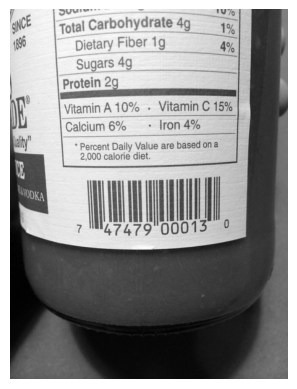

In [673]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

Calculamos la representacion de magnitud gradiente de Sharr de las imagenes en los dos ejes

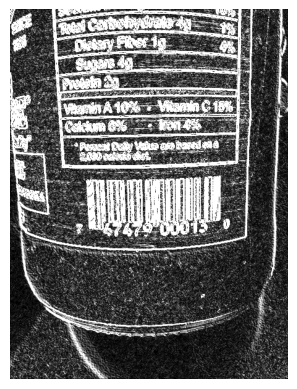

In [674]:
gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.imshow(gradient, cmap='gray')
plt.axis('off')
plt.show()

Rotacion fallida

In [675]:
# # Aplicar el detector de bordes Canny
# bordes = cv2.Canny(gray, 10, 240, L2gradient = True)

# # Mostrar los bordes detectados
# cv2.imshow('Bordes Canny', bordes)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # Transformada de Hough para detectar líneas
# lines = cv2.HoughLinesP(bordes, 1, np.pi/180, 40, minLineLength=30, maxLineGap=15)

# # Vamos a obter la orientación dominante de las líneas detectadas
# if lines is not None:
#     all_angles = []
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         dx = x2-x1
#         dy = y2-y1
#         angle = np.degrees(np.arctan2(dy, dx))
#         all_angles.append(angle)

#     dominant_angle = np.median(all_angles)

#     if -90 <= dominant_angle < 0:
#         rotacion = dominant_angle #-47º
#     elif 0 <= dominant_angle < 90:
#         rotacion = 90 - dominant_angle #47º
#     elif -180 < dominant_angle < -90:
#         rotacion = (180 + dominant_angle) + 90 #-133º
#     else:
#         rotacion = 90 - (180 - dominant_angle) #133º

# # Calculamos el centro de la imagen para la rotación
# alto, ancho = resized_image.shape[0:2]
# centro = (ancho // 2, alto // 2)
# angulo = rotacion
# escala = 1.0

# # Matriz de rotacion
# matriz_rotacion = cv2.getRotationMatrix2D(centro, angulo, escala)

# # Aplicamos la rotacion
# imagen_rotada = cv2.warpAffine(resized_image, matriz_rotacion, (ancho, alto))

# # Mostrar la imagen con las líneas detectadas
# cv2.imshow('Deteccion de lineas', imagen_rotada)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

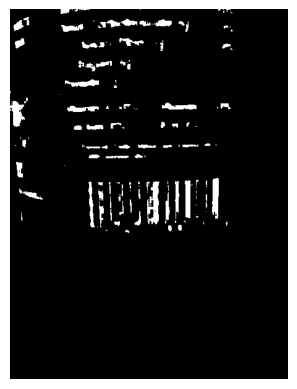

In [676]:
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

Hacemos closing morfológico para unir las barras en una masa

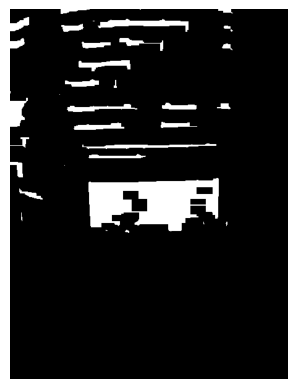

In [677]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Limpieza básica
closed = cv2.dilate(closed, None, iterations=4)
closed = cv2.erode(closed, None, iterations=4)

plt.imshow(closed, cmap='gray')
plt.axis('off')
plt.show()

Encontramos los contornos en la imagen procesada

In [678]:
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

Hacemos un bounding box alrededor del contorno más grande

In [679]:
rect = cv2.minAreaRect(c)
print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = box.astype(int)

((232.9718017578125, 318.8648986816406), (83.80912017822266, 210.52235412597656), 88.3316650390625)


Vamos a comprobar que nos devuelve esto

In [680]:
print(box)

[[126 280]
 [336 273]
 [339 357]
 [128 363]]


Vamos a hacer más obvio y comprensible su output

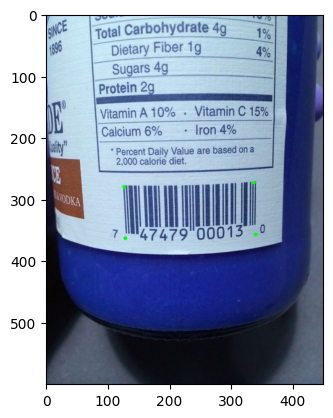

In [681]:
imagen_copia = img.copy()
for i in box:
    cv2.circle(img,(i[0],i[1]), 3, (0,255,0), -1)
imgplot = plt.imshow(img)
plt.show()

Vamos a guardar la rotacion, altura y anchura para poner la imagen derecha

In [682]:
angulo = rect[2]
alto, ancho = img.shape[0:2]
if angulo < -45:
    angulo = -(90 + angulo)
else:
    angulo = angulo - 90
matriz_rotacion = cv2.getRotationMatrix2D(rect[0], angulo, 1.0)
imagen_rotada = cv2.warpAffine(img, matriz_rotacion, (ancho, alto))
imagen_copia = cv2.warpAffine(imagen_copia, matriz_rotacion, (ancho, alto))

Rotamos el área del dibujo del código de barras

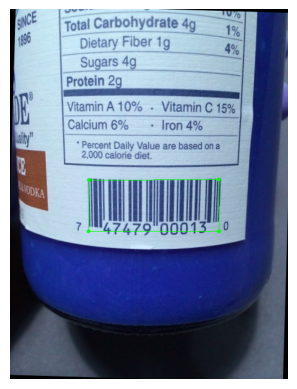

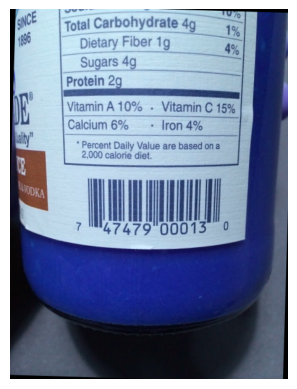

In [683]:
pts_rotados = cv2.transform(np.array([box]), matriz_rotacion)[0]

cv2.drawContours(imagen_rotada, [pts_rotados], -1, (0, 255, 0), 1)
imgplot = plt.imshow(imagen_rotada)
plt.axis('off')
plt.show()

plt.imshow(imagen_copia)
plt.axis('off')
plt.show()

Recortamos la imagen

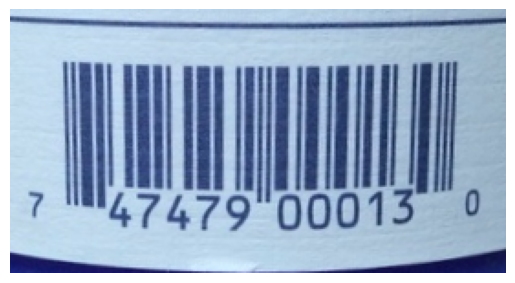

In [684]:
# Bounding box tras rotar
xs = pts_rotados[:, 0]
ys = pts_rotados[:, 1]

# Cogemos las coordenadas minimas y maximas ya que sino la imagen recortada sale mal
x_min, x_max = xs.min()-30, xs.max()+30
y_min, y_max = ys.min()-30, ys.max()+30

# Recortamos la imagen
imagen_recortada = imagen_copia[y_min:y_max, x_min:x_max]
imgplot = plt.imshow(imagen_recortada)
plt.axis('off')
plt.show()

Aquí debería implementar por mi mismo la interpretación del código de barras. Pero dejo una versión ya implementada de lo que debería ser

In [685]:
# def read_barcodes(img):
#     for d in decode(img):
#         img = cv2.rectangle(img, (d.rect.left, d.rect.top), (d.rect.left + d.rect.width, d.rect.top + d.rect.height), (0, 255, 0), 2)
#         img = cv2.putText(img, d.data.decode(), (d.rect.left, d.rect.top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
#     return img

# img = read_barcodes(imagen_recortada)
# imgplot = plt.imshow(img)
# plt.axis('off')
# plt.show()

Para que la imagen sea mas facil de procesar la binarizamos (solo blanco y negro)

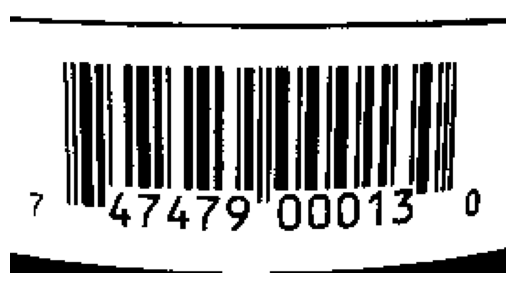

In [686]:
gray = cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (1, 1), 0) # Aplicar un filtro Gaussiano para reducir el ruido
val, thresh_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.axis("off")
plt.imshow(thresh_img, cmap = "gray")
plt.show()

Calculamos el centro de la imagen solo para asegurarnos de que el barcode se encuentra en el centro de la imagen.

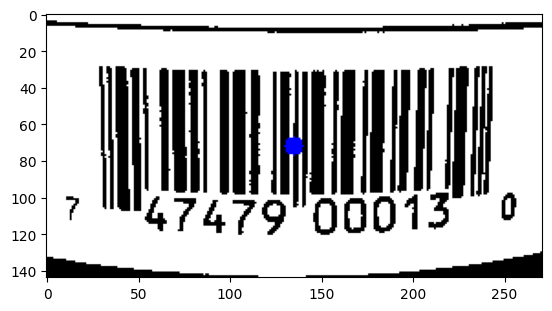

In [687]:
alto, ancho = thresh_img.shape[:2]

# Calcular las coordenadas del centro
centro_x = ancho // 2
centro_y = alto // 2

img_con_centro = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)

# Dibujar un círculo en el centro
cv2.circle(img_con_centro, (centro_x, centro_y), 5, (0, 0, 255), -1)
plt.imshow(img_con_centro)
plt.show()

Dibujamos una linea recta en medio de la imagen

Linea escaneada:
[255 255 255 255 255   0   0 255 255   0   0   0 255 255   0   0   0   0
   0   0 255 255   0   0   0   0   0 255 255   0   0 255 255 255 255 255
 255 255   0   0   0   0 255 255   0   0   0   0   0   0   0 255 255 255
   0   0   0   0 255 255 255   0   0 255 255 255 255 255 255 255   0   0
   0   0   0 255 255   0   0   0   0   0   0   0 255 255 255   0   0   0
   0 255 255 255 255 255 255 255 255   0   0 255 255   0   0   0   0   0
 255 255   0   0   0 255 255   0   0   0 255 255   0   0   0   0   0   0
   0 255 255 255 255 255   0   0 255 255   0   0   0   0   0   0   0   0
 255 255 255 255   0   0 255 255   0   0   0   0   0   0   0 255 255 255
 255 255   0   0 255 255   0   0   0   0   0 255 255 255 255   0   0   0
   0   0 255   0   0   0 255 255 255 255 255 255 255 255   0   0 255 255
   0   0   0   0   0   0 255 255 255 255   0   0 255 255   0   0 255   0
   0   0 255 255 255]


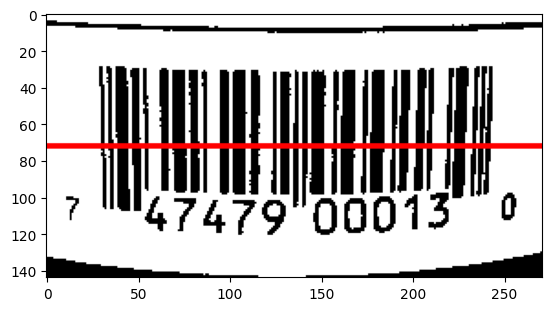

In [ ]:
fila_central_idx = alto // 2
scan_line = thresh_img[fila_central_idx, 25:ancho-25] # Esto es debido a que le hemos añadido un ancho de 30 pixles

thresh_linea = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
cv2.line(thresh_linea, (0, fila_central_idx), (ancho, fila_central_idx), (255, 0, 0), 2)
plt.imshow(thresh_linea)

print("Linea escaneada:")
print(scan_line)

Limpiamos la deteccion de barcode. Esto es por que a veces detecta los lados blancos (255) de la imagen antes del codigo negro (0).

In [689]:
scan_line = scan_line.tolist()

count = 0
for val in scan_line:
    if val == 255:
        count += 1
    else:
        break

scan_line = scan_line[count:]
count = 0

for val in scan_line[::-1]:
    if val == 255:
        count += 1
    else:
        break

scan_line = scan_line[:-count]
print(scan_line)

for i in range(len(scan_line)):
    if scan_line[i] == 255:
        scan_line[i] = 0
    else:
        scan_line[i] = 1

print(scan_line)

[0, 0, 255, 255, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 255, 255, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0]
[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,

Vamos a calcular los anchos de las diferentes barras del código de barras. Como nota, es interesante saber que el lado derecho del código tiene un número par de barras, mientras que el lado izquierdo tiene un número impar de barras.

In [690]:
def calcular_anchos(lista_pixeles):
    anchos = []
    if not lista_pixeles:
        return anchos
    
    contador = 0
    valor_actual = lista_pixeles[0]

    for pixel in lista_pixeles:
        if pixel == valor_actual:
            contador += 1
        else:
            anchos.append(contador)
            valor_actual = pixel
            contador = 1
    anchos.append(contador)
    return anchos

anchos_en_pixeles = calcular_anchos(scan_line)
print(f"Anchos en píxeles: {anchos_en_pixeles}")

Anchos en píxeles: [2, 2, 3, 2, 6, 2, 5, 2, 2, 7, 4, 2, 7, 3, 4, 3, 2, 7, 5, 2, 7, 3, 4, 8, 2, 2, 5, 2, 3, 2, 3, 2, 7, 5, 2, 2, 8, 4, 2, 2, 7, 5, 2, 2, 5, 4, 5, 1, 3, 8, 2, 2, 6, 4, 2, 2, 2, 1, 3]


Ahora lo que queremos es detectar los códigos de barras en la imagen. Para ello voy a crear unos diccionarios de EAN-13 que es el estándar que se usa en los códigos de barras.

In [ ]:
# === Diccionarios EAN-13 ===

# Paridades de los 6 primeros dígitos para obtener el primer dígito
# (L = 0, G = 1)
FIRST_DIGIT_PARITY = {
    "LLLLLL": 0,
    "LLGLGG": 1,
    "LLGGLG": 2,
    "LLGGGL": 3,
    "LGLLGG": 4,
    "LGGLLG": 5,
    "LGGGLL": 6,
    "LGLGLG": 7,
    "LGLGGL": 8,
    "LGGLGL": 9,
}

L_CODES_MAP = {
    (3, 2, 1, 1): 0,
    (2, 2, 2, 1): 1,
    (2, 1, 2, 2): 2,
    (1, 4, 1, 1): 3,
    (1, 1, 3, 2): 4,
    (1, 2, 3, 1): 5,
    (1, 1, 1, 4): 6,
    (1, 3, 1, 2): 7,
    (1, 2, 1, 3): 8,
    (3, 1, 1, 2): 9,
}

G_CODES_MAP = {
    (1, 1, 2, 3): 0,
    (1, 2, 2, 2): 1,
    (2, 2, 1, 2): 2,
    (1, 1, 4, 1): 3,
    (2, 3, 1, 1): 4,
    (1, 3, 2, 1): 5,
    (4, 1, 1, 1): 6,
    (2, 1, 3, 1): 7,
    (3, 1, 2, 1): 8,
    (2, 1, 1, 3): 9,
}

Es importante tener en cuenta que el EAN-13 funciona con unidades relativas llamadas módulos, 30 en total.

- Barra fina = 1 módulo.
- Barra ancha = 2, 3 o 4 módulos.

Entonces ahora cómo sabemos cuánto mide 1 módulo en las imagenes? Usando el patrón obtenido antes ya que los 3 primeros elementos (Negro-Blanco-Negro) simpre suman 3 módulos de ancho.

1. Mis primeros 3 anchos son: 2, 2, 3 píxeles.
2. Suma: $2 + 2 + 3 = 7$ píxeles totales para el guardia.
3. Calculamos el tamaño de 1 módulo (X): $7 \text{ píxeles} / 3 \text{ módulos} = 2.33$ píxeles por módulo.

También dividimos el ancho que hemos obtenido para no tener en cuenta los guard bars.


In [ ]:
ancho_total_guardia = sum(anchos_en_pixeles[:3])
modulo_unitario = ancho_total_guardia / 3.0

anchos_modulos = [round(x / modulo_unitario) for x in anchos_en_pixeles]
for i in range(len(anchos_modulos)):
    if anchos_modulos[i] == 0:
        anchos_modulos[i] = 1
print(anchos_modulos)

# Dividimos en mitades
inicio_izq = 3 
fin_izq = inicio_izq + 24

inicio_central = fin_izq
fin_central = inicio_central + 5

inicio_der = fin_central
fin_der = inicio_der + 24

primera_mitad = anchos_modulos[inicio_izq : fin_izq]
segunda_mitad = anchos_modulos[inicio_der : fin_der]

print(f"Primera mitad ({len(primera_mitad)} elementos): {primera_mitad}")
print(f"Segunda mitad ({len(segunda_mitad)} elementos): {segunda_mitad}")

# Verificación de seguridad
if len(primera_mitad) != 24 or len(segunda_mitad) != 24:
    print("Revisar la detección de bordes.")

[1, 1, 1, 1, 3, 1, 2, 1, 1, 3, 2, 1, 3, 1, 2, 1, 1, 3, 2, 1, 3, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 2, 2, 2, 1, 1, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1]
Primera mitad (24 elementos): [1, 3, 1, 2, 1, 1, 3, 2, 1, 3, 1, 2, 1, 1, 3, 2, 1, 3, 1, 2, 3, 1, 1, 2]
Segunda mitad (24 elementos): [3, 2, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 2, 2, 2, 1, 1, 3, 1, 1, 3, 2, 1, 1]


Vamos a decodificar nuestros primeros dígitos.

In [737]:
def decodificar(mitad):

    decoded_digits = []
    parity_pattern = ""

    for i in range(0, len(mitad), 4):
        chunk = tuple(mitad[i : i+4])
        
        digit = None
        code_type = None

        if chunk in L_CODES_MAP:
            digit = L_CODES_MAP[chunk]
            code_type = "L"
            
        elif chunk in G_CODES_MAP:
            digit = G_CODES_MAP[chunk]
            code_type = "G"
            
        if digit is not None:
            decoded_digits.append(digit)
            parity_pattern += code_type
        else:
            print(f"ERROR: Patrón no encontrado en L ni G.")

    if parity_pattern in FIRST_DIGIT_PARITY:
        decoded_digits.insert(0, FIRST_DIGIT_PARITY[parity_pattern])
    else:
        print("ERROR: Paridad no encontrada en FIRST_DIGIT_PARITY.")
    
    return decoded_digits

decoded_digits = decodificar(primera_mitad)
decoded_digits += (decodificar(segunda_mitad))
print(decoded_digits)

ERROR: Patrón no encontrado en L ni G.
ERROR: Paridad no encontrada en FIRST_DIGIT_PARITY.
[0, 7, 4, 7, 4, 7, 9, 0, 0, 0, 1, 0]
